In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time, math
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [206]:
ratings_path = "/content/gdrive/MyDrive/ml-1m/ratings.dat"
movie_path = "/content/gdrive/MyDrive/ml-1m/movies.dat"

names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(my_path, sep='::', names=names)


movies = pd.read_csv(movie_path, sep='::', header=None, usecols=[1])
movies.columns = ['title']

ratings.head()
movies.iloc[[2,5]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


title
2  Grumpier Old Men (1995)
5              Heat (1995)

Text(0.5, 1.0, 'Distribution of ratings')

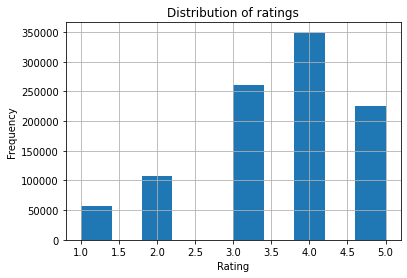

In [198]:
from sklearn.preprocessing import scale

ratings['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')


In [204]:
X = ratings[['user_id', 'movie_id']].values
y = ratings['rating'].values
print(X)
print(y)

[[   1 1193]
 [   1  661]
 [   1  914]
 ...
 [6040  562]
 [6040 1096]
 [6040 1097]]
[5 3 3 ... 5 4 4]


In [203]:
from scipy.sparse import csr_matrix
def create_rating_matrix(X, y, dim):
  r = X[:,0]
  c = X[:,1]
  matrix = sparse.csr_matrix((y, (r,c)), shape=(dim[0] + 1, dim[0] + 1))
  M = matrix.todense()
  M = M[1:,1:]
  M = np.asarray(M)
  return M

# dim = (np.unique(np.array(X[:,0])).size, np.unique(np.array(X[:,1])).size)
initial_rating_matrix = create_rating_matrix(X, y, (users, movies))
print(initial_rating_matrix)



[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]


In [202]:
users = len(ratings['user_id'].unique())
movies = len(ratings['movie_id'].unique())
def train(predicted_rating_matrix, users, movies, X, y):
  M = create_rating_matrix(X, y, (users, movies))
  model = NMF(n_components=20, init='random', random_state=0, alpha = 0.01, l1_ratio = 0, max_iter = 15)
  W = model.fit_transform(predicted_rating_matrix)
  H = model.components_.T
  P = H.dot(W.T).T            
  P[P > 5] = 5.                   
  P[P < 1] = 1.
  return P, H

initial_rating_matrix = create_rating_matrix(X, y, (users, movies))
predicted_rating_matrix, _ = train(initial_rating_matrix, users, movies, X, y)

print(predicted_rating_matrix[:10])

[[2.05846967 1.         1.         ... 1.         1.         1.        ]
 [1.76781615 1.         1.         ... 1.         1.         1.        ]
 [1.30000687 1.         1.         ... 1.         1.         1.        ]
 ...
 [1.72042436 1.         1.         ... 1.         1.         1.        ]
 [1.89550203 1.         1.         ... 1.         1.         1.        ]
 [5.         2.2559699  1.30109548 ... 1.         1.         1.        ]]


In [208]:
initial_rating_matrix = create_rating_matrix(X, y, (users, movies))
predicted_rating_matrix, _ = train(initial_rating_matrix, users, movies, X, y)


def make_recommendation_for_an_existing_user(initial_rating_matrix, predicted_rating_matrix, movies, user_idx, k=5):
    user_ratings = pd.DataFrame(initial_rating_matrix).iloc[user_idx, :]              
    user_prediction = pd.DataFrame(predicted_rating_matrix).iloc[user_idx,:]
    preferred_movies = np.flip(np.argsort(np.array(user_ratings))[-k:])
    recommended_movies = np.flip(np.argsort(np.array(user_prediction))[-k:])

    print("Preferred movies: ")
    print(movies.iloc[preferred_movies])
    print()
    print("Recommended movies: ") 
    print(movies.iloc[recommended_movies])

make_recommendation_for_an_existing_user(initial_rating_matrix, predicted_rating_matrix, movies, user_idx=10, k=5)

Preferred movies: 
                                          title
2579                        Frankenstein (1931)
1783                      Love Walked In (1998)
592                            Pinocchio (1940)
2108                         Family Plot (1976)
763   Touki Bouki (Journey of the Hyena) (1973)

Recommended movies: 
                             title
295           Pushing Hands (1992)
49      Usual Suspects, The (1995)
607   Hellraiser: Bloodline (1996)
2857              Hairspray (1988)
1264         Big Sleep, The (1946)
